In [76]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

print(tf. __version__) 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

2.6.2
Num GPUs Available:  1


## Processing Data

In [77]:
def get_features_and_target():
    df = pd.read_csv(f'../output_dir/cypress_hill_mpb/mpb.csv')

    feature = df['year'].values.reshape(-1, 1).astype('float32')
    target = df['sum_of_mpb_infestations'].values.reshape(-1, 1).astype('float32')

    feature_mean = np.mean(feature, axis=0)
    feature_std = np.std(feature, axis=0)
    feature_std[feature_std == 0] = 1

    target_mean = np.mean(target, axis=0)
    target_std = np.std(target, axis=0)
    target_std[target_std == 0] = 1

    feature = (feature - feature_mean) / feature_std
    target = (target - target_mean) / target_std

    return feature, target




## Model Building

In [120]:
def kfold_model_train():
    
    # Model Configuration
    models = []
    model_histories = []
    batch_size = 10
    no_epochs = 100
    num_folds = 5
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss_function = 'mse'

    feature, target = get_features_and_target()
    
    # Define the K-fold Cross Validator
    loss_per_fold = []
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(feature, target):

        # Define the model architecture
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=(1, )))
        model.add(tf.keras.layers.Dense(10, activation='relu'))
        model.add(tf.keras.layers.Dense(10, activation='relu'))
        model.add(tf.keras.layers.Dense(1))

        # Compile the model
        model.compile(loss=loss_function,
                    optimizer=optimizer)
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        # Fit data to model
        history = model.fit(feature[train], target[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=0)
        models.append(model)
        model_histories.append(history)
        
        # Generate generalization metrics
        score = model.evaluate(feature[test], target[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {score}')
        loss_per_fold.append(score)
        
        #Increase fold number 
        fold_no += 1
        
        # == Provide average scores ==
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(0, len(loss_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print('------------------------------------------------------------------------')
        

        return models, model_histories
        

## Graph Loss

In [121]:
def graph_loss(model_history):

    history = model_history.history

    train_loss = history['loss']

    plt.plot(train_loss, '-b', label='Training loss')

    plt.title("MPB's Training Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'MPBLossGraph', bbox_inches='tight')
    plt.show()
    

## Running Experiment

In [122]:
models, histories = kfold_model_train()

------------------------------------------------------------------------
Training for fold 1 ...


2021-12-01 12:09:24.936979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Score for fold 1: loss of 0.0634629875421524
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0634629875421524
------------------------------------------------------------------------
Average scores for all folds:
> Loss: 0.0634629875421524
------------------------------------------------------------------------


2021-12-01 12:09:25.370141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


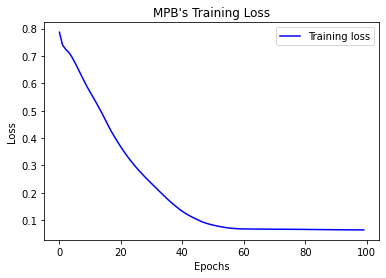

In [123]:
graph_loss(histories[0])